In [95]:
import numpy as np
import pandas as pd

In [96]:
# "Iris Data Set"
iris_feature = np.loadtxt("bezdekIris.data",dtype=np.str,delimiter=',')[:,0:-1].astype(float)
label_map = np.loadtxt("bezdekIris.data",dtype=np.str,delimiter=',')[:,-1]

iris_label = np.zeros([len(label_map)],dtype=np.int) # Iris-setosa 0 Iris-versicolor 1 Iris-virginica 2
iris_label[label_map=='Iris-versicolor'] = 1 
iris_label[label_map=='Iris-virginica'] = 2 

In [97]:
#from sklearn.datasets import make_classification
#noise = make_classification(n_samples=30, n_features=4)
#noise_feature = noise[0]
#noise_label = np.ones(30)*4

In [98]:
#iris_feature = np.append(iris_feature,noise_feature,axis=0)
#iris_label = np.append(iris_label,noise_label)

In [99]:
iris_label.shape

(150,)

In [100]:
def _hcm_criterion(x, v): 
    
    # Calculate the distance between each center and all samples
    distance_matrix = np.zeros((len(x),len(v)))
    for idx in range(len(x)):
        for c in range(len(v)):
            distance_matrix[idx][c] = np.linalg.norm(x[idx]-v[c])
    
    cluster_to = np.argmin(distance_matrix, axis=1)
    
    u = np.zeros((v.shape[0], x.shape[0]))
    for i in range(x.shape[0]):
        u[cluster_to[i]][i] = 1

    return u

In [101]:
def _fcm_criterion(x, v, q):
    # Calculate the distance between each center and all samples
    distance_matrix = np.zeros((len(x),len(v)))
    for idx in range(len(x)):
        for c in range(len(v)):
            distance_matrix[idx][c] = np.linalg.norm(x[idx]-v[c])

    distance_matrix =  distance_matrix.T
    
    # Avoid zeros
    d =  distance_matrix + np.finfo(float).eps
    d = d **  (-2. / (q - 1))
    u = d / np.sum(d, axis=0, keepdims=1)
    
    return u

In [102]:
def _pcm_criterion(x, v, eta, q):
    # Calculate the distance between each center and all samples
    distance_matrix = np.zeros((len(x),len(v)))
    for idx in range(len(x)):
        for c in range(len(v)):
            distance_matrix[idx][c] = np.linalg.norm(x[idx]-v[c])

    # Avoid zeros
    d =  distance_matrix + np.finfo(float).eps
    
    d2 = ((d ** 2) / eta).T 
    d2 = d2 ** (1. / (q - 1))
    u = 1. / (1. + d2)

    return u

In [103]:
def _update_clusters(x, u, m):
    um = u ** m
    new_center = um.dot(x) / np.expand_dims(um.sum(axis=1), axis=1)
    
    return new_center

In [104]:
def myhcm(x, cluster_num, error=1e-6, max_iterations=1000):
    sample_num, feature_num  = x.shape
    
    # Pick random values from dataset being prototypes
    center = np.array(x[np.random.choice(sample_num, cluster_num, replace=False), :])
    
    # Membership Matrix Each Data Point in eah cluster
    membership = np.zeros((cluster_num, sample_num))

    for iterations in range(0, max_iterations):
        next_membership = _hcm_criterion(x, center)
        next_center = _update_clusters(x, next_membership , 1)

        # Stopping Criteria
        if np.linalg.norm(next_center - center) < error:
            break

        center = next_center
        membership = next_membership
    
    print("Total iteration:",iterations)
    return center, membership

In [105]:
def myfcm(x, cluster_num, fuzzification_factor =1.2, error=1e-6, max_iterations=1000):
    sample_num, feature_num  = x.shape
    
    # Pick random values from dataset being prototypes
    center = np.array(x[np.random.choice(sample_num, cluster_num, replace=False), :])
    
    # Membership Matrix Each Data Point in eah cluster
    membership = np.zeros((cluster_num, sample_num))

    for iterations in range(0, max_iterations):
        next_membership = _fcm_criterion(x, center,fuzzification_factor)
        next_center = _update_clusters(x, next_membership , fuzzification_factor)

        # Stopping Criteria
        if np.linalg.norm(next_center - center) < error:
            break

        center = next_center
        membership = next_membership
        
    print("Total iteration:",iterations)
    return center, membership

In [106]:
def mypcm(x, cluster_num, fuzzification_factor =1.2, eta=2 , error=1e-6, max_iterations=1000):
    sample_num, feature_num  = x.shape
    
    # approach is to initialize PCM using FCM.)
    center, membership = myfcm(x, cluster_num, fuzzification_factor =fuzzification_factor, error=error, max_iterations=100)

    for iterations in range(0, max_iterations):
        next_membership = _pcm_criterion(x, center,eta, fuzzification_factor)
        next_center = _update_clusters(x, next_membership , fuzzification_factor)
        
        # Stopping Criteria
        if np.linalg.norm(next_center - center) < error:
            break

        center = next_center
        membership = next_membership

    print("Total iteration:",iterations)
    return center, membership

In [107]:
class PCA:
    def __init__(self):
        return
    def fit(self,feature, component=2):
        feature_num = feature.shape[1]
        
        eig_vecs, eig_vals, V = np.linalg.svd(feature.T)
        self.eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
        
        self.component = np.hstack((self.eig_pairs[0][1].reshape(feature_num,1), 
                          self.eig_pairs[1][1].reshape(feature_num,1)))
        
        for i in range(2,component):
            self.component = np.hstack((self.component, self.eig_pairs[i][1].reshape(feature_num,1)))
        
    def transform(self,feature):
        return feature@self.component
    
    def get_componet(self):
        return self.component
    
    def get_eignepair(self):
        return self.eig_pairs

In [108]:
def confusion_mat(true,pred):
    K = len(np.unique(true)) # Number of classes 
    result = np.zeros((K, K))

    for i in range(len(true)):
        result[true[i]][pred[i]] += 1

    return result

In [109]:
def C2(a):
    if(a>=2):
        return a*(a-1) / 2
    else:
        return 0

In [110]:
## Using formula from wiki: https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index

def ARI(true, pred):
    result = confusion_mat(true, pred)
    a_sum = np.sum(result,axis = 0)
    b_sum = np.sum(result,axis = 1)
    
    result = np.ravel(result)
    a = 0
    sample_size = 0
    for idx in range(len((result))):
        sample_size += result[idx]
        a +=  C2(result[idx])
    
    b1 = 0
    b2 = 0
    for idx in range(len((a_sum))):
        b1 += C2(a_sum[idx])  
        b2 += C2(b_sum[idx]) 
        
    b = (b1*b2)/C2(sample_size)
    c = 1/2 * (b1+b2)
    
    return (a - b) / (c - b)

In [111]:
from matplotlib import pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score,davies_bouldin_score

def plot(x,v,u,true_label):
    feature = x
    
    pca = PCA()
    pca.fit(x,component=2)
    x = pca.transform(x)
    v = pca.transform(v)
   
    cluster_membership = np.argmax(u, axis=0)
    
    centroids_label = np.zeros(v.shape[0])
    for i in range(v.shape[0]):
        centroids_label[i] = i
    
    
    plt.figure(figsize=(12.4,4.8))
    plt.subplot(121)
    plt.title('cluster result')
    scatter = plt.scatter(x[:,0], x[:,1], c=cluster_membership,  alpha=0.5, cmap='gist_rainbow')
    legend1 = plt.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    plt.gca().add_artist(legend1)
    
    plt.grid(True)
    
    plt.subplot(122)
    plt.title('original distribution')

    scatter = plt.scatter(x[:, 0], x[:, 1], c=true_label,  alpha=0.5, cmap='gist_rainbow')
    legend1 = plt.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    plt.gca().add_artist(legend1)
    plt.grid(True)
    plt.show()
    
   
    print("Adjusted Rand Index",adjusted_rand_score(true_label,cluster_membership))
    print("Normalized Mutual Information",normalized_mutual_info_score(true_label,cluster_membership))
    print("Davies Bouldin score",davies_bouldin_score(feature,cluster_membership))
    
    return davies_bouldin_score(feature,cluster_membership)

In [112]:
v, u = myhcm(iris_feature, 3)

Total iteration: 5


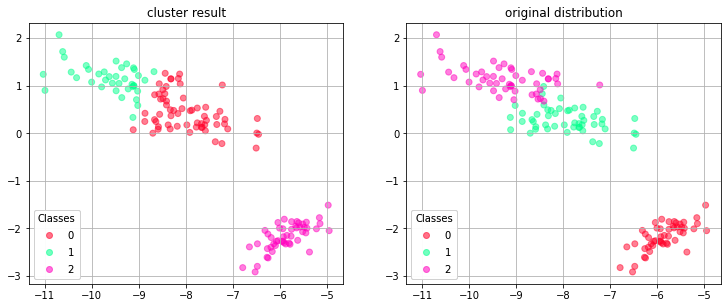

Adjusted Rand Index 0.7302382722834697
Normalized Mutual Information 0.7581756800057784
Davies Bouldin score 0.6619715465007527


0.6619715465007527

In [113]:
plot(iris_feature, v, u,iris_label)

In [114]:
v, u = myfcm(iris_feature, 3)

Total iteration: 17


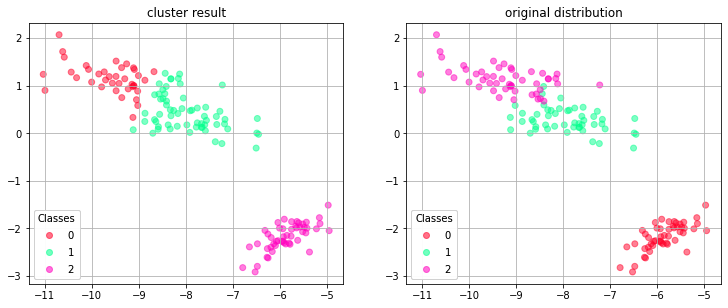

Adjusted Rand Index 0.7302382722834697
Normalized Mutual Information 0.7581756800057784
Davies Bouldin score 0.6619715465007527


0.6619715465007527

In [115]:
plot(iris_feature, v, u, iris_label)

In [116]:
v, u = mypcm(iris_feature, 3, fuzzification_factor=30, eta = 1)

Total iteration: 0
Total iteration: 32


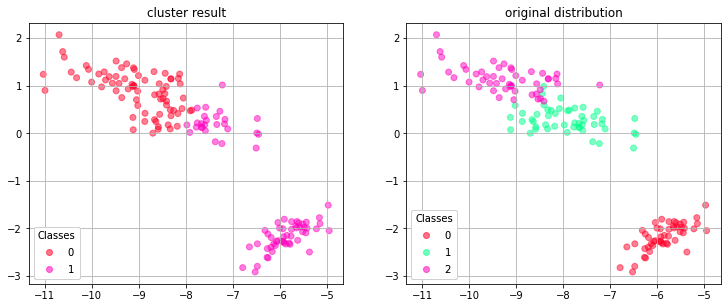

Adjusted Rand Index 0.4217047320495596
Normalized Mutual Information 0.47925051598914137
Davies Bouldin score 0.6419028061803089


0.6419028061803089

In [117]:
plot(iris_feature, v, u, iris_label)

2
Total iteration: 12


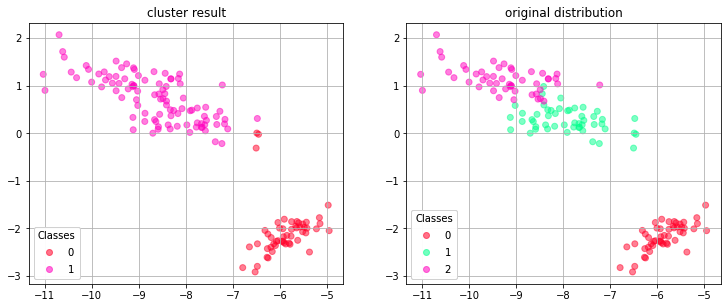

Adjusted Rand Index 0.5399218294207123
Normalized Mutual Information 0.6565191143081124
Davies Bouldin score 0.4042928371730438
3
Total iteration: 15


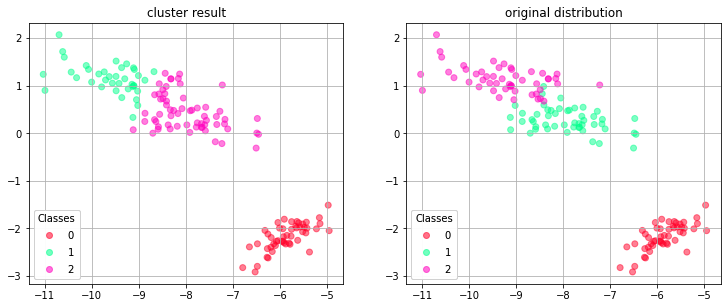

Adjusted Rand Index 0.7302382722834697
Normalized Mutual Information 0.7581756800057784
Davies Bouldin score 0.6619715465007528
4
Total iteration: 92


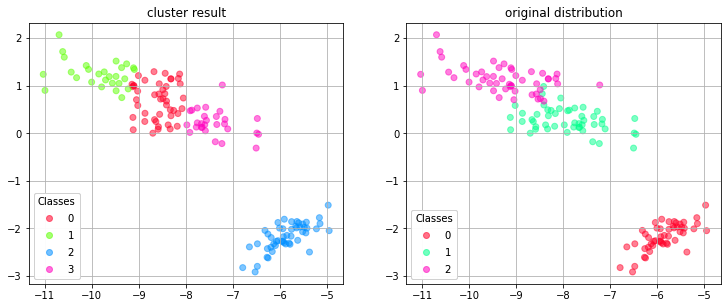

Adjusted Rand Index 0.6162452219303186
Normalized Mutual Information 0.7042391572146458
Davies Bouldin score 0.7706132699619447
5
Total iteration: 44


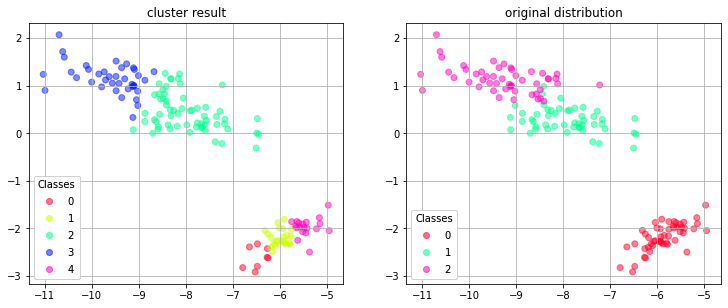

Adjusted Rand Index 0.5512539815996392
Normalized Mutual Information 0.6559593676205118
Davies Bouldin score 0.9051950421553265
6
Total iteration: 49


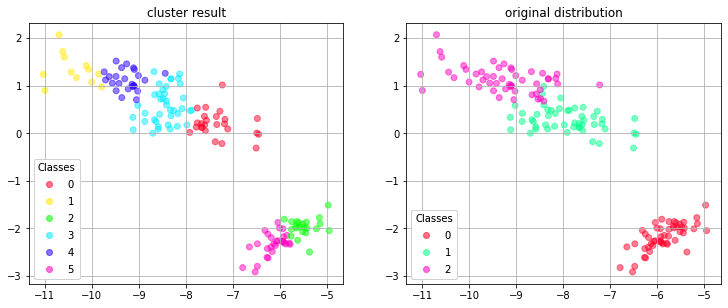

Adjusted Rand Index 0.44753353143335994
Normalized Mutual Information 0.6379538800046878
Davies Bouldin score 0.9141579726538064
7
Total iteration: 106


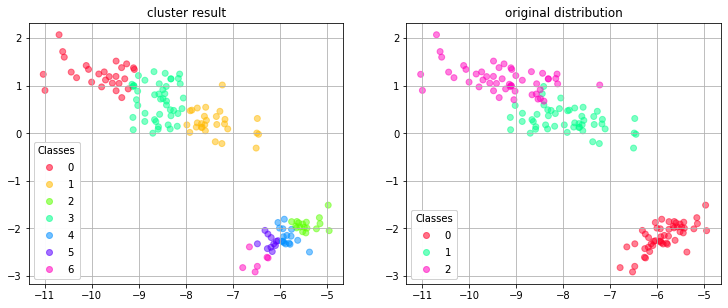

Adjusted Rand Index 0.38376670194977525
Normalized Mutual Information 0.5970164027487782
Davies Bouldin score 1.1164015641788971
8
Total iteration: 26


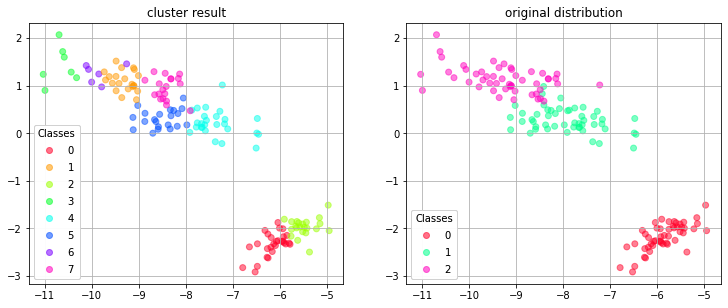

Adjusted Rand Index 0.4573922249540009
Normalized Mutual Information 0.6524425157136193
Davies Bouldin score 1.030333777138449
9
Total iteration: 45


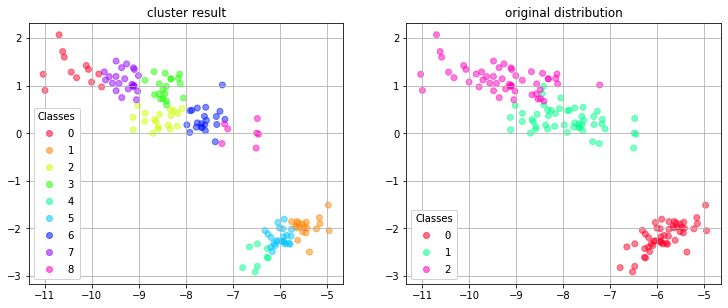

Adjusted Rand Index 0.391156379624616
Normalized Mutual Information 0.6233922705815522
Davies Bouldin score 0.9850528282355483
10
Total iteration: 64


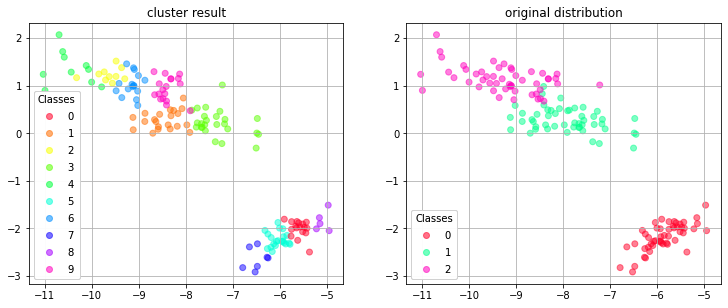

Adjusted Rand Index 0.3626385310595837
Normalized Mutual Information 0.5942964615510464
Davies Bouldin score 1.0813243932175616


In [118]:
i_list = []
dv_list = []

for c in range(2,11):
    print(c)
    v, u = myfcm(iris_feature , c)
    dv = plot(iris_feature, v, u, iris_label )
    i_list.append(c)
    dv_list.append(dv)

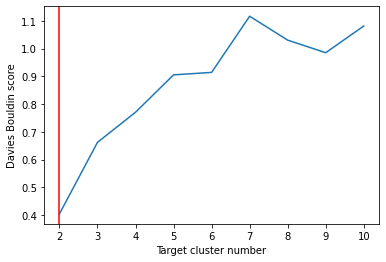

In [119]:
plt.xlabel('Target cluster number')
plt.ylabel('Davies Bouldin score')
plt.plot(i_list,dv_list)
plt.axvline(x=i_list[np.argsort(dv_list)[0]], color='r', linestyle='-')
plt.show()